INFO:root:正在从 /home/adminroot/lxx/openpi/code/openpi/test/dataset_transfer/uav_flow/test/episode_data_0.json 加载数据...
INFO:root:正在连接到服务器 ws://0.0.0.0:8000
INFO:root:Waiting for server at ws://0.0.0.0:8000...
INFO:root:开始循环推理...
INFO:root:正在执行推理步: 1-10
INFO:root:正在执行推理步: 11-20
INFO:root:正在执行推理步: 21-30
INFO:root:正在执行推理步: 31-40
INFO:root:推理完成。
INFO:root:正在生成轨迹对比图...



--- 轨迹偏差分析 ---
平均绝对位置误差 (Positional MAE): 2.4227
平均绝对姿态误差 (Rotational MAE): 1.9653

每个点的具体位置误差:
  点 0: 0.0000
  点 1: 0.0087
  点 2: 0.0179
  点 3: 0.0139
  点 4: 0.0755
  点 5: 0.1635
  点 6: 0.2734
  点 7: 0.4212
  点 8: 0.5988
  点 9: 0.8250
  点 10: 1.0770
  点 11: 1.2629
  点 12: 1.4252
  点 13: 1.5817
  点 14: 1.7486
  点 15: 1.9046
  点 16: 2.0754
  点 17: 2.2540
  点 18: 2.4412
  点 19: 2.6165
  点 20: 2.8106
  点 21: 3.0625
  点 22: 3.1706
  点 23: 3.3309
  点 24: 3.4795
  点 25: 3.5957
  点 26: 3.8297
  点 27: 3.9660
  点 28: 4.0573
  点 29: 4.1569
  点 30: 4.4170
  点 31: 4.5830
  点 32: 4.7014
  点 33: 4.8410
  点 34: 4.9338
  点 35: 4.9616
  点 36: 4.9560
------------------------



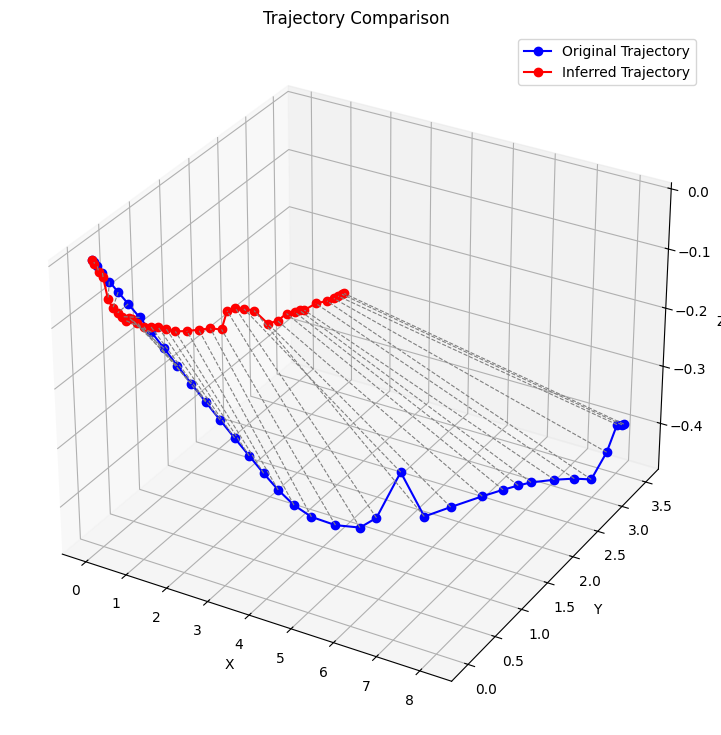

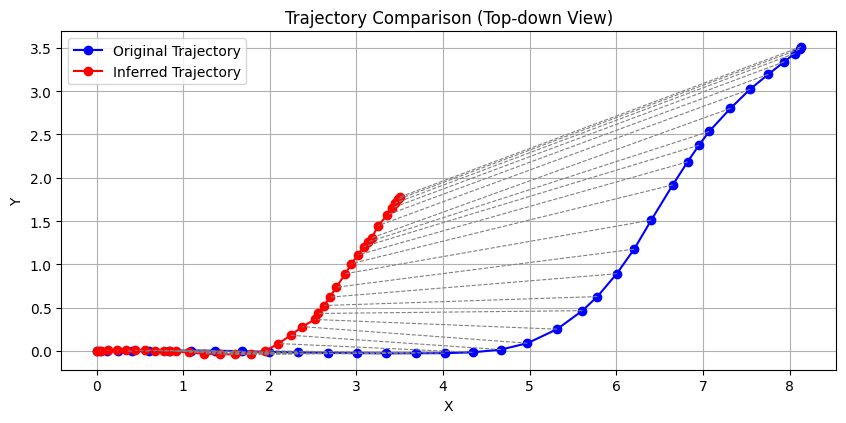

INFO:root:正在保存推理轨迹到 /home/adminroot/lxx/openpi/code/openpi/test/infer/inferred_trajectory.json...
INFO:root:推理轨迹已保存到 /home/adminroot/lxx/openpi/code/openpi/test/infer/inferred_trajectory.json


In [2]:
import json
import logging

import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from openpi_client import websocket_client_policy as _websocket_client_policy


def calculate_trajectory_deviation(traj1, traj2):
    """
    计算两条轨迹的位置和姿态偏差。
    轨迹应为 (N, 6) 的形状，其中 N 是点数，6是 (x, y, z, roll, pitch, yaw)。
    """
    pos1, rot1 = traj1[:, :3], traj1[:, 3:]
    pos2, rot2 = traj2[:, :3], traj2[:, 3:]

    positional_errors = np.linalg.norm(pos1 - pos2, axis=1)
    positional_mae = np.mean(positional_errors)

    rotational_errors = np.abs(rot1 - rot2)
    rotational_mae = np.mean(rotational_errors)

    return positional_mae, rotational_mae, positional_errors


def visualize_trajectories_3d(traj1, traj2):
    """
    使用 matplotlib 可视化两条3D轨迹。
    """
    pos1 = traj1[:, :3]
    pos2 = traj2[:, :3]

    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(pos1[:, 0], pos1[:, 1], pos1[:, 2], 'o-', label='Original Trajectory', color='blue')
    ax.plot(pos2[:, 0], pos2[:, 1], pos2[:, 2], 'o-', label='Inferred Trajectory', color='red')

    for i in range(len(pos1)):
        ax.plot([pos1[i, 0], pos2[i, 0]], [pos1[i, 1], pos2[i, 1]], [pos1[i, 2], pos2[i, 2]],
                '--', color='gray', linewidth=0.8)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Trajectory Comparison')
    ax.legend()
    plt.show()

def visualize_trajectories_2d_topdown(traj1, traj2):
    """
    使用 matplotlib 可视化两条轨迹的俯视图。
    """
    pos1 = traj1[:, :2]  # 只取 X, Y 坐标
    pos2 = traj2[:, :2]  # 只取 X, Y 坐标

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.plot(pos1[:, 0], pos1[:, 1], 'o-', label='Original Trajectory', color='blue')
    ax.plot(pos2[:, 0], pos2[:, 1], 'o-', label='Inferred Trajectory', color='red')

    for i in range(len(pos1)):
        ax.plot([pos1[i, 0], pos2[i, 0]], [pos1[i, 1], pos2[i, 1]],
                '--', color='gray', linewidth=0.8)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Trajectory Comparison (Top-down View)')
    ax.legend()
    ax.grid(True)
    ax.set_aspect('equal', adjustable='box')
    plt.show()    


def main():
    HOST = "0.0.0.0"
    PORT = 8000
    EPISODE_DATA_PATH = "/home/adminroot/lxx/openpi/code/openpi/test/dataset_transfer/uav_flow/test/episode_data_0.json"
    PROMPT = "Go to the tree on the right side"
    REPLAN_STEPS = 10  # 每次推理后取前10个动作

    logging.info(f"正在从 {EPISODE_DATA_PATH} 加载数据...")
    with open(EPISODE_DATA_PATH, 'r') as f:
        episode_data = json.load(f)

    MAX_STEPS = len(episode_data)  # 将总步数设置为数据中的对象数量

    # 1. 构造原始轨迹
    # 原始轨迹由第0帧的状态和之后每一帧的动作组成
    # 注意：在数据集中，frame_i 的 state 等于 frame_i-1 的 actions
    # 因此，真实的轨迹点是所有 object 的 state 加上最后一个 object 的 actions
    original_trajectory_states = [np.array(d['state']) for d in episode_data]
    original_trajectory_states.append(np.array(episode_data[-1]['actions']))
    original_trajectory = np.array(original_trajectory_states)


    logging.info(f"正在连接到服务器 ws://{HOST}:{PORT}")
    client = _websocket_client_policy.WebsocketClientPolicy(HOST, PORT)

    all_inferred_actions = []
    
    # 2. 首次推理
    # 使用第一个 object 的数据进行初始化
    current_state = np.array(episode_data[0]['state'])
    image_path = episode_data[0]['image_path']
    wrist_image_path = episode_data[0]['wrist_image_path']
    
    logging.info("开始循环推理...")
    for i in range(0, MAX_STEPS, REPLAN_STEPS):
        logging.info(f"正在执行推理步: {i+1}-{i+REPLAN_STEPS}")
        
        # 3. 构造输入 example
        # image 固定不变, wrist_image 和 state 变化
        wrist_image_path = episode_data[i]['wrist_image_path']
        
        element = {
            "observation/image": imageio.imread(image_path),
            "observation/wrist_image": imageio.imread(wrist_image_path),
            "observation/state": current_state,
            "prompt": PROMPT
        }

        # 4. 调用 server 进行推理
        action_chunk = client.infer(element)["actions"]
        all_inferred_actions.extend(action_chunk)

        # 5. 更新下一次推理的状态
        # 使用返回的动作序列的最后一个点的6D位姿作为下一次的起始状态
        current_state = np.array(action_chunk[-1][:6])

    logging.info("推理完成。")

    # 6. 构造推理轨迹
    # 推理出的轨迹是初始状态加上所有推理出的动作
    inferred_trajectory_states = [np.array(episode_data[0]['state'])]
    inferred_trajectory_states.extend([np.array(act[:6]) for act in all_inferred_actions])
    inferred_trajectory = np.array(inferred_trajectory_states)
    
    # 确保两条轨迹长度一致以便比较
    min_len = min(len(original_trajectory), len(inferred_trajectory))
    original_trajectory = original_trajectory[:min_len]
    inferred_trajectory = inferred_trajectory[:min_len]

    # 7. 计算偏差并输出结果
    pos_mae, rot_mae, pos_errors = calculate_trajectory_deviation(original_trajectory, inferred_trajectory)

    print("\n--- 轨迹偏差分析 ---")
    print(f"平均绝对位置误差 (Positional MAE): {pos_mae:.4f}")
    print(f"平均绝对姿态误差 (Rotational MAE): {rot_mae:.4f}")
    print("\n每个点的具体位置误差:")
    for i, err in enumerate(pos_errors):
        print(f"  点 {i}: {err:.4f}")
    print("------------------------\n")

    # 8. 可视化轨迹
    logging.info("正在生成轨迹对比图...")
    visualize_trajectories_3d(original_trajectory, inferred_trajectory)
    visualize_trajectories_2d_topdown(original_trajectory, inferred_trajectory)

    # 9. 保存推理轨迹到JSON文件
    output_path = "/home/adminroot/lxx/openpi/code/openpi/test/infer/inferred_trajectory.json"
    logging.info(f"正在保存推理轨迹到 {output_path}...")

    # 将numpy数组转换为可序列化的列表
    trajectory_data = {
        "inferred_trajectory": [state.tolist() for state in inferred_trajectory]
    }
    
    with open(output_path, 'w') as f:
        json.dump(trajectory_data, f, indent=4)
    
    logging.info(f"推理轨迹已保存到 {output_path}")

if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO)
    main()